# Partie A)

- Équation du problème : 

$\frac{\partial C}{\partial t} - \frac{D_{eff}}{r} \frac{\partial C}{\partial r} - D_{eff} \frac{\partial^2 C}{\partial r^2} + S = 0 $

- Solution à l'équilibre avec $\frac{\partial C}{\partial t} = 0$, donc :

$ - \frac{D_{eff}}{r} \frac{\partial C}{\partial r} - D_{eff} \frac{\partial^2 C}{\partial r^2} + S = 0 $

- Avec la méthode des problèmes proches, on a $C(r) = Sp$ et le therme source résiduel e : 

$ - \frac{D_{eff}}{r} \frac{\partial Sp}{\partial r} - D_{eff} \frac{\partial^2 Sp}{\partial r^2} + S(Sp) = - e $



In [32]:
%load_ext autoreload

In [33]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from diffusion import Diffusion
from validation import NearProblem, ManufacturedSol
import sympy
from IPython.display import clear_output
from scipy.stats import linregress
import time
from utils import *
from mansols import mms_cos, mms_source_cos
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

# Partie A

- Résoudre le problème de diffusion avec la méthode des problèmes proches

In [287]:
NePro = NearProblem(101)
C2, R2 = NePro.solve_with_residual(verbose=True, max_solve_time=5.0, step_size=1e8, solve_tol=1e-9, min_time=1e4)

Time step size : 100000.0 seconds
Concentration at half domain : 3.1046591392440797
Iteration : 374
Relative change : 4.608945189015829e-07
Timed out for n = 375


In [288]:
print('Validation de l\'interpolation spline :')
print('Norme L1   :', nL1(NePro.spl(NePro.R_ref), NePro.C_ref))
print('Norme L2   :', nL2(NePro.spl(R2), NePro.C_ref))
print('Norme Linf :', nLi(NePro.spl(R2), NePro.C_ref))

print('\n Validation de l\'erreur avec MNP :')
print('Norme L1   :', nL1(C2, NePro.C_ref))
print('Norme L2   :', nL2(C2, NePro.C_ref))
print('Norme Linf :', nLi(C2, NePro.C_ref))

Validation de l'interpolation spline :
Norme L1   : 6.331568932515744e-16
Norme L2   : 9.723066966520205e-17
Norme Linf : 3.552713678800501e-15

 Validation de l'erreur avec MNP :
Norme L1   : 5.5848975820016355e-05
Norme L2   : 5.7419713102226025e-06
Norme Linf : 7.170014449719986e-05


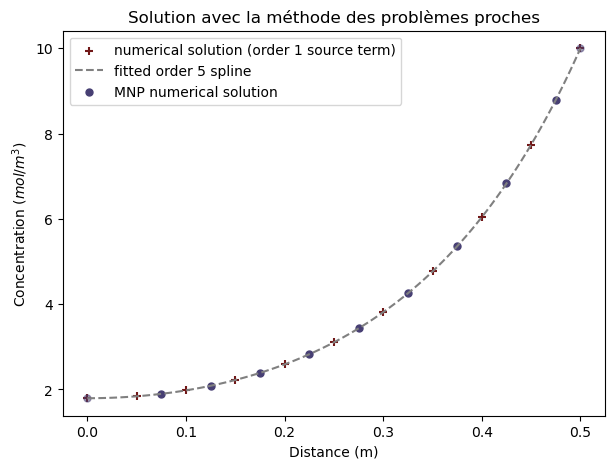

In [289]:
fig, ax = plt.subplots(figsize=(7,5))
plt.scatter(NePro.R_ref[::10], NePro.C_ref[::10], 30, marker='+', color='#711818', label='numerical solution (order 1 source term)')
plt.plot(NePro.R_ref, NePro.spl(NePro.R_ref), linestyle='--', color='0.5', label='fitted order 5 spline')
plt.scatter(NePro.R_ref[15::10], C2[15::10], 25, color='#473F73', label='MNP numerical solution')
plt.scatter(NePro.R_ref[0], C2[0], 25, color='#473F73', alpha=0.5)
plt.scatter(NePro.R_ref[-1], C2[-1], 25, color='#473F73', alpha=0.5)

ax.set_xlabel('Distance (m)')
ax.set_ylabel(r'Concentration $(mol/m^3)$')
ax.set_title('Solution avec la méthode des problèmes proches')
plt.legend()
plt.show()

In [290]:
NL1 = []
NL2 = []
NLi = []
problem_sizes = np.logspace(1, 3, 10)
for n in problem_sizes:
    NePro = NearProblem(int(n))
    Ci, _ = NePro.solve_with_residual(verbose=True, max_solve_time=5.0, step_size=1e8, solve_tol=1e-9)
    NL1.append(nL1(Ci, NePro.C_ref))
    NL2.append(nL2(Ci, NePro.C_ref))
    NLi.append(nLi(Ci, NePro.C_ref))
    


Time step size : 100000000.0 seconds
Concentration at half domain : 3.1075278553636223
Iteration : 10
Relative change : 5.132683612267705e-07


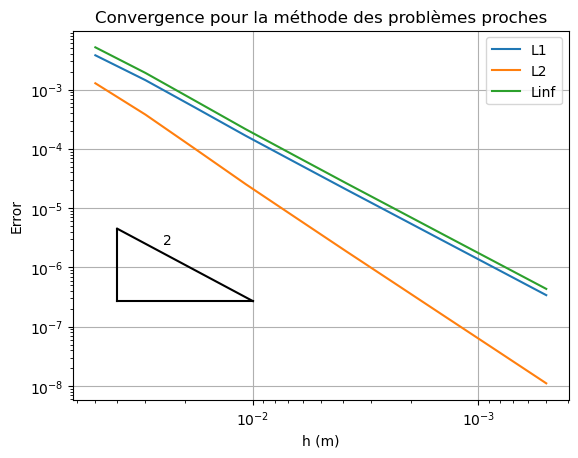

In [291]:
plt.plot(0.5/problem_sizes, NL1, label='L1')
plt.plot(0.5/problem_sizes, NL2, label='L2')
plt.plot(0.5/problem_sizes, NLi, label='Linf')


plt.plot([0.04, 0.01], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.04], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.01], [2.7e-7, 2.7e-7], color='k')
plt.annotate('2', (0.025, 2.5e-6))

slopes = []
errors = {'L1':NL1, 'L2':NL2, 'Linf':NLi}

ax = plt.gca()
ax.invert_xaxis()
ax.set_xlabel('h (m)')
ax.set_ylabel('Error')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Convergence pour la méthode des problèmes proches')
ax.grid()

### Ordres de convergence

In [295]:
errors = {'L1   :':NL1, 'L2   :':NL2, 'Linf :':NLi}

for err in errors:
    result = linregress(np.log(0.5/problem_sizes), np.log(errors[err]))
    print(err, result.slope, result.intercept)

L1   : 2.031554196743305 0.525919569122955
L2   : 2.5402806346995095 0.9611016589213612
Linf : 2.0434080577059994 0.846144020634096


# Partie B) : Méthode des solutions manufacturées

In [129]:
from sympy import symbols, exp, cos, pi, diff, latex, log

r, t, R, Cs, De = symbols('r t R Cs De')

expr = (Cs/2) * (1 - cos(pi * r /R)) + log(t)*r**2*(r-R)

def Lop(expr):
    return diff(expr, t) - (De/r)*diff(expr, r) - De * diff(expr, r, 2)

def dirichlet(expr):
    return expr.evalf(subs={r:0.5, R:0.5, Cs:10.0})

def neuman(expr):
    return diff(expr, r).evalf(subs={r:0, R:0.5, Cs:10.0})
print('Residual')

print('symmetry')
display(neuman(expr))
print('dirichlet')
display(dirichlet(expr))

display(expr)
display(Lop(expr))

Residual
symmetry


0

dirichlet


10.0000000000000

Cs*(1 - cos(pi*r/R))/2 + r**2*(-R + r)*log(t)

-De*(pi**2*Cs*cos(pi*r/R)/(2*R**2) + 4*r*log(t) - 2*(R - r)*log(t)) - De*(pi*Cs*sin(pi*r/R)/(2*R) + r**2*log(t) + 2*r*(-R + r)*log(t))/r + r**2*(-R + r)/t

$C(r, t) = \frac{Cs \left(1 - \cos{\left(\frac{\pi r}{R} \right)}\right)}{2} + r^{2} \left(- R + r \right) \log{\left(t \right)}$

In [105]:
def mms_source_time(r, t):
    De = 1e-10
    Cs = 10.0
    R = 0.5
    r = np.max([r, np.ones_like(r)*1e-20], axis=0)
    t = np.max([t, np.ones_like(t)*1e-20], axis=0)
    T1 = - De*(np.pi**2*Cs*np.cos(np.pi*r/R)/(2*R**2) + 4*r*np.log(t) - 2*(R - r)*np.log(t)) 
    T2 = - De*(np.pi*Cs*np.sin(np.pi*r/R)/(2*R) + r**2*np.log(t) + 2*r*(-R + r)*np.log(t))/r 
    T3 = r**2*(-R + r)/t
    return T1 + T2 + T3

def mms_time(r, t):
    Cs = 10.0
    R = 0.5
    return Cs*(1 - np.cos(np.pi*r/R))/2 + r**2*(-R + r)*np.log(t+1)

Text(0.5, 1.0, 'manufatured solution with time component')

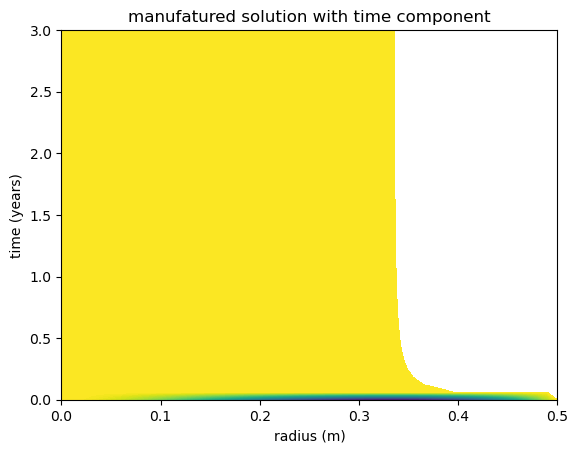

In [106]:
t = np.linspace(0, (3600*24*365)*3)
r = np.linspace(0, 0.5)
R, T = np.meshgrid(r, t)
C = mms_source_time(R, T)
plt.contourf(R, T/(3600*24*365), C, levels=100)
ax = plt.gca()
ax.set_ylabel('time (years)')
ax.set_xlabel('radius (m)')
ax.set_title('manufatured solution with time component')

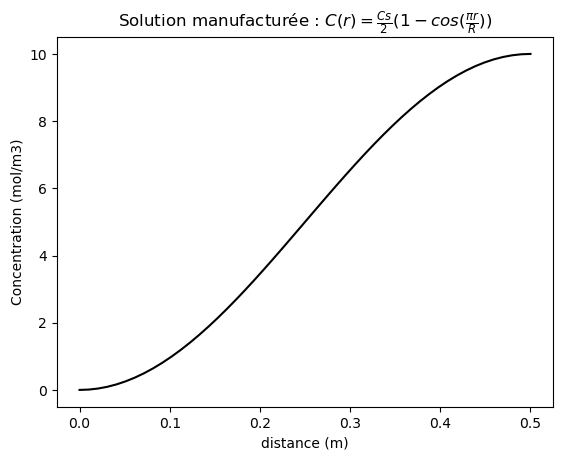

In [94]:
r_vals = np.linspace(0, 0.5)
plt.plot(r_vals, mms_cos(r_vals), color='k')
ax = plt.gca()
ax.set_xlabel('distance (m)')
ax.set_ylabel('Concentration (mol/m3)')
ax.set_title(r'Solution manufacturée : $C(r) = \frac{Cs}{2} (1 - cos(\frac{\pi r}{R}))$')
plt.show()

Time step size : 1000000000.0 seconds
Concentration at half domain : 4.563916267968399
Iteration : 1264
Relative change : 0.009651408083741158
Timed out for n = 1265


Text(0, 0.5, 'Concentration (mol/m3)')

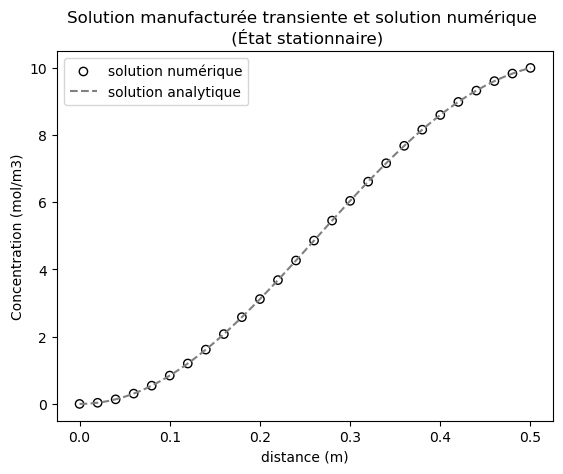

In [127]:
sol = ManufacturedSol(101, mms_source_time)
Cmn, Rmn = sol.solve_with_residual(verbose=True, max_solve_time=10.0, min_steps=100, step_size=1e9, solve_tol=1e-9)
plt.scatter(Rmn[::4], Cmn[::4], edgecolor='k', facecolors='none', label='solution numérique')
plt.plot(Rmn, mms_time(Rmn, sol.t), color='0.5', linestyle="--", label='solution analytique')
plt.title('Solution manufacturée transiente et solution numérique \n (État stationnaire)')
plt.legend()
plt.gca().set_xlabel('distance (m)')
plt.gca().set_ylabel('Concentration (mol/m3)')

In [130]:
print('Erreur avec la MMS : ')
print('L1   : ', nL1(Cmn ,mms_time(Rmn, NePro.t)))
print('L2   : ', nL2(Cmn ,mms_time(Rmn, NePro.t)))
print('Linf : ', nLi(Cmn ,mms_time(Rmn, NePro.t)))

Erreur avec la MMS : 
L1   :  0.00866838187510057
L2   :  0.0009846258232183913
Linf :  0.014796502841328163


In [122]:
NL1 = []
NL2 = []
NLi = []
problem_sizes = np.logspace(1, 3, 10)

for n in problem_sizes:
    NePro = ManufacturedSol(int(n), mms_source_time)
    Ci, Ri = NePro.solve_with_residual(verbose=True, max_solve_time=30.0, step_size=1e9, solve_tol=1e-9)
    NL1.append(nL1(Ci, mms_time(Ri, NePro.t)))
    NL2.append(nL2(Ci, mms_time(Ri, NePro.t)))
    NLi.append(nLi(Ci, mms_time(Ri, NePro.t)))
    

Time step size : 1000000000.0 seconds
Concentration at half domain : 4.584235358407482
Iteration : 579
Relative change : 0.06664901471597746
Timed out for n = 580


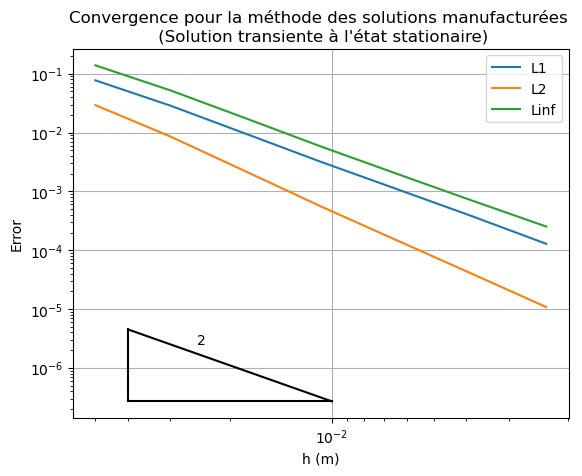

In [128]:
plt.plot(0.5/problem_sizes[:-3], NL1[:-3], label='L1')
plt.plot(0.5/problem_sizes[:-3], NL2[:-3], label='L2')
plt.plot(0.5/problem_sizes[:-3], NLi[:-3], label='Linf')


plt.plot([0.04, 0.01], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.04], [4.5e-6, 2.7e-7], color='k')
plt.plot([0.04, 0.01], [2.7e-7, 2.7e-7], color='k')
plt.annotate('2', (0.025, 2.5e-6))


ax = plt.gca()
ax.invert_xaxis()
ax.set_xlabel('h (m)')
ax.set_ylabel('Error')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Convergence pour la méthode des solutions manufacturées \n (Solution transiente à l\'état stationaire)')
ax.grid()

In [131]:
errors = {'L1   :':NL1, 'L2   :':NL2, 'Linf :':NLi}

for err in errors:
    result = linregress(np.log(0.5/problem_sizes), np.log(errors[err]))
    print(err, result.slope, result.intercept)

L1   : 1.815946579826405 2.5482914846290523
L2   : 2.317893972622007 3.0903801565782363
Linf : 1.8028784979010182 3.1030859279214846
